In [1]:
import sys
import os
from outletsBiasRatings import outletsBiasRatingsAllSides,outletAbbreviationToFullName
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from joblib import Parallel, delayed
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [2]:
outletsBiasRatings = outletsBiasRatingsAllSides
outlets = list(outletsBiasRatings.keys())

outletsL = [o for o in outlets if outletsBiasRatings[o] < 0]
outletsR = [o for o in outlets if outletsBiasRatings[o] > 0]
outletsC = [o for o in outlets if outletsBiasRatings[o] == 0]
startYear = 2000
endYear = 2019
emotions=['anger','disgust','fear','joy','sadness', 'neutral'] #j-hartmann/emotion-english-distilroberta-base #No surprise category since model underperforms for that category according to ground truth of human annotations 
years=[str(year) for year in range(startYear,endYear+1)]

print(years)
print(len(outlets))
print("outletsAll" , outlets)
print("outletsL" , outletsL)
print("outletsC" , outletsC)
print("outletsR" , outletsR)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
47
outletsAll ['alternet', 'democracynow', 'db', 'hp', 'theintercept', 'jacobin', 'motherjones', 'thenewyorker', 'thenation', 'slate', 'vox', 'cnn', 'nyt', 'abcnews', 'theatlantic', 'buzzfeed', 'cbs', 'economist', 'guardian', 'nbcnews', 'politico', 'timemagazine', 'wp', 'npr', 'ap', 'bbc', 'bloomberg', 'csm', 'reuters', 'thehill', 'usatoday', 'wsj', 'reason', 'we', 'wt', 'fox', 'americanspectator', 'bre', 'theblaze', 'cbn', 'dailycaller', 'dailymail', 'dailywire', 'thefederalist', 'nationalreview', 'nyp', 'newsmax']
outletsL ['alternet', 'democracynow', 'db', 'hp', 'theintercept', 'jacobin', 'motherjones', 'thenewyorker', 'thenation', 'slate', 'vox', 'cnn', 'nyt', 'abcnews', 'theatlantic', 'buzzfeed', 'cbs', 'economist', 'guardian', 'nbcnews', 'politico', 'timemagazine', 'wp', 'npr']
outletsC ['ap', 'bbc', 'bloomberg', 'csm', '

## Load emotions

In [3]:
with open('emotionsDictionary.pickle', 'rb') as handle:
    emotionsDictionary = pickle.load(handle)

In [4]:
def getMatrixOfEmotionTimeSeriesInOutlets(emotionsDictionary,emotion,outlets,startYear,endYear):
    years=[str(year) for year in range(startYear,endYear+1)]
    m=np.zeros([len(outlets),len(years)])
    for outletIndex, outlet in enumerate(outlets):
        for yearIndex, year in enumerate(years):
            try:
                m[outletIndex,yearIndex]=emotionsDictionary[outlet][year][emotion]
            except KeyError:
                m[outletIndex,yearIndex]=np.nan
    return m

In [5]:
def normalizeWordMatrix(m):
    maximumInEachRow = np.nanmax(m, axis=1)  # Get max frequency for each outlet
    normalized_m = m / maximumInEachRow.reshape(-1,1)  # Divide each frequency by maximum frequency in the outlet time series
    return normalized_m

In [6]:
def getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outlets,startYear,endYear,normalize=False,z=1.96):
    m=getMatrixOfEmotionTimeSeriesInOutlets(emotionsDictionary,emotion,outlets,startYear,endYear)    
    
    if normalize == True:
        m = normalizeWordMatrix(m)
    xYears = [item for item in list(range(startYear, endYear + 1))]

    n = np.sum(~np.isnan(m), axis=0)  # number of obs in each time interval

    # Aggregate the metrics of several outlets
    mAverage = np.nanmean(m, axis=0)  # Proper way when nan values are present

    # Confidence intervals
    mStd = np.nanstd(m, axis=0)

    z = 1.96  # for a 95% C
    #     z = 2.58 # for a 99% C
    #     z = 3.291 # for a 99.9% C
    CI = z * (mStd / np.sqrt(n))
    stde = mStd / np.sqrt(n)

    return (xYears, mAverage, CI, stde)
    

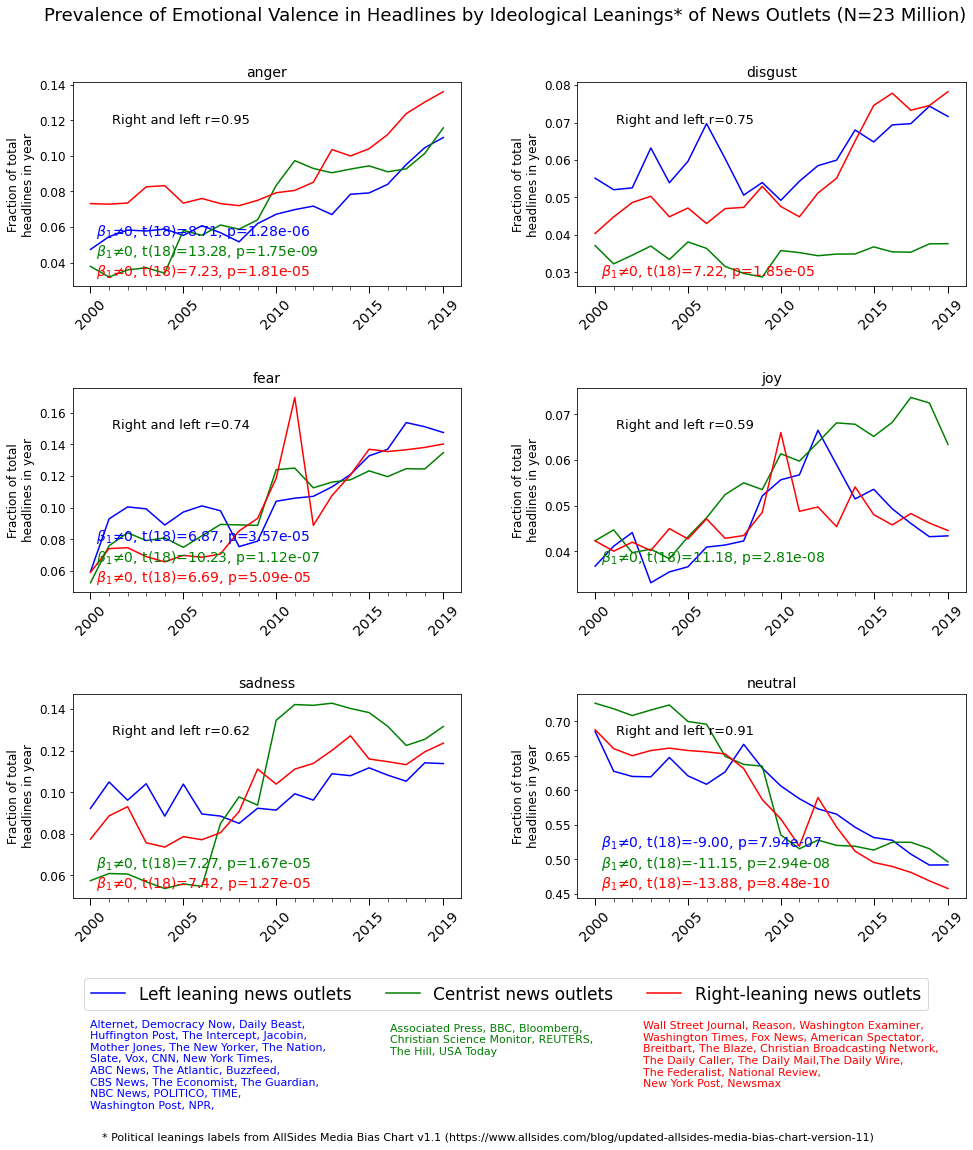

In [8]:
startYear=2000
endYear=2019
years=[str(year) for year in range(startYear,endYear+1)]
yearsInts=[int(year) for year in years]
df=len(yearsInts)-2 
fig, axs = plt.subplots(3, 2,figsize=(16,15)) 

for emotionIndex, emotion in enumerate(emotions):
    
    row=emotionIndex//2
    column=emotionIndex%2
    years,mAverageL, CIL, stdeL = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outletsL,startYear,endYear,normalize=False,z=1.96)
    years,mAverageC, CIC, stdeC = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outletsC,startYear,endYear,normalize=False,z=1.96)
    years,mAverageR, CIR, stdeR = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outletsR,startYear,endYear,normalize=False,z=1.96)
    
    axs[row, column].plot(years,mAverageL,color="blue", label="Left leaning news outlets")
#     axs[row, column].errorbar(years, mAverageL, yerr=stdeL, color="blue", alpha= 0.3,capsize=0)
    
    axs[row, column].plot(years,mAverageC,color="green", label="Centrist news outlets")
#     axs[row, column].errorbar(years, mAverageC, yerr=stdeC, color="green", alpha= 0.3,capsize=0)
    
    axs[row, column].plot(years,mAverageR,color="red", label="Right-leaning news outlets")
#     axs[row, column].errorbar(years, mAverageR, yerr=stdeR, color="red", alpha= 0.3,capsize=0)
    
    axs[row, column].set_ylabel("Fraction of total\nheadlines in year",fontsize=12)
#     rRandL=np.corrcoef(mAverageL,mAverageR)[0][1]
#     axs[row, column].text(0.1,0.8,"r="+str(rRandL)[:4],transform=axs[row,column].transAxes,fontsize=12)

    #Right and left correlation
    rRandL=np.corrcoef(mAverageL,mAverageR)[0][1]
    axs[row, column].text(0.1,0.8,"Right and left r="+str(rRandL)[:4],transform=axs[row,column].transAxes,fontsize=13)

    axs[row, column].xaxis.set_major_locator(MultipleLocator(5))
    axs[row, column].xaxis.set_minor_locator(MultipleLocator(1))
    axs[row, column].tick_params(axis="x", which="major", length=7,width=1)        
    axs[row, column].tick_params(axis="x", which="minor", length=4) 
    axs[row, column].tick_params(axis='y',labelsize=12)
    axs[row, column].set_xticks(years[::5]+[2019])
    axs[row, column].set_xticklabels(years[::5]+[2019], rotation=45,fontsize=14 )
    
    #Regression slope test
    significanceThreshold=0.01
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageL)
    p_value=multipletests([p_value]*3*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    sL=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    if p_value < significanceThreshold:
        plt.text(0.05,0.25,sL,transform=axs[row, column].transAxes,fontsize=14,color="b")        
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageC)
    p_value=multipletests([p_value]*3*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    sC=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    if p_value < significanceThreshold:
        plt.text(0.05,0.15,sC,transform=axs[row, column].transAxes,fontsize=14,color="g")        
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageR)
    p_value=multipletests([p_value]*3*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    sR=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    if p_value < significanceThreshold:
        plt.text(0.05,0.05,sR,transform=axs[row, column].transAxes,fontsize=14,color="r")        
    
    axs[row, column].set_title(f'{emotion}',fontsize=14)

outletsStringL="""Alternet, Democracy Now, Daily Beast,\nHuffington Post, The Intercept, Jacobin,\nMother Jones, The New Yorker, The Nation,\nSlate, Vox, CNN, New York Times,\nABC News, The Atlantic, Buzzfeed,\nCBS News, The Economist, The Guardian,\nNBC News, POLITICO, TIME,\nWashington Post, NPR,"""
outletsStringC="""Associated Press, BBC, Bloomberg,\nChristian Science Monitor, REUTERS,\nThe Hill, USA Today"""
outletsStringR="""Wall Street Journal, Reason, Washington Examiner,\nWashington Times, Fox News, American Spectator,\nBreitbart, The Blaze, Christian Broadcasting Network,\nThe Daily Caller, The Daily Mail,The Daily Wire,\nThe Federalist, National Review,\nNew York Post, Newsmax"""

axs[row,0].legend(loc=(0.03,-0.55),ncol=3,fontsize=17)  

plt.figtext(0.14, -0.07, outletsStringL, horizontalalignment='left', fontsize=11, color='b')     
plt.figtext(0.40, -0.02, outletsStringC, horizontalalignment='left', fontsize=11, color='g')     
plt.figtext(0.62, -0.05, outletsStringR, horizontalalignment='left', fontsize=11, color='r')     

plt.subplots_adjust(hspace = 0.5,wspace = 0.3)    
figureTitle="Prevalence of Emotional Valence in Headlines by Ideological Leanings* of News Outlets (N=23 Million)"
st=fig.suptitle(figureTitle, y=0.95, fontsize=18)   
plt.figtext(0.15, -0.10, "* Political leanings labels from AllSides Media Bias Chart v1.1 (https://www.allsides.com/blog/updated-allsides-media-bias-chart-version-11)", horizontalalignment='left', fontsize=11, color='k')     
fig.savefig('../manuscript/figures/2-4emotionalityOfHeadlines47OutletsByIdeology.png',dpi=400,bbox_inches='tight',pad_inches=0)#High-resolution    
   

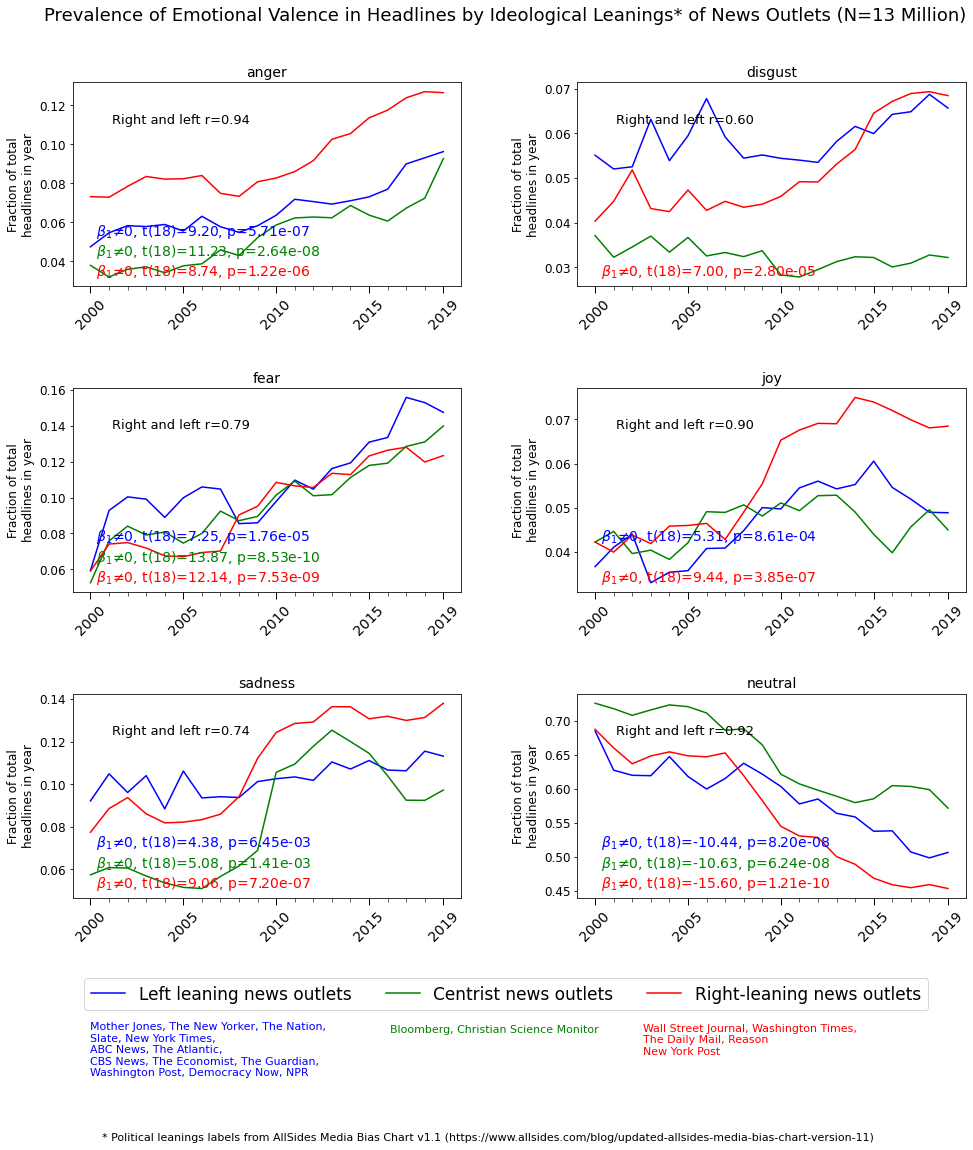

In [12]:
startYear=2000
endYear=2019
years=[str(year) for year in range(startYear,endYear+1)]
yearsInts=[int(year) for year in years]
outlets = ['nyp','dailymail','wt','wsj','csm','bloomberg','wp','guardian','economist','cbs','nyt','slate',
          'thenewyorker','thenation','theatlantic','reason','npr','abcnews','democracynow','motherjones'
          ]

outletsL = [outlet for outlet in outlets if outletsBiasRatingsAllSides[outlet]<0]
outletsC = [outlet for outlet in outlets if outletsBiasRatingsAllSides[outlet]==0]
outletsR = [outlet for outlet in outlets if outletsBiasRatingsAllSides[outlet]>0]

df=len(yearsInts)-2 
fig, axs = plt.subplots(3, 2,figsize=(16,15)) 
for emotionIndex, emotion in enumerate(emotions):
    row=emotionIndex//2
    column=emotionIndex%2
    years,mAverageL, CIL, stdeL = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outletsL,startYear,endYear,normalize=False,z=1.96)
    years,mAverageC, CIC, stdeC = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outletsC,startYear,endYear,normalize=False,z=1.96)
    years,mAverageR, CIR, stdeR = getAverageEmotionAcrossOutlets(emotionsDictionary,emotion,outletsR,startYear,endYear,normalize=False,z=1.96)
    
    axs[row, column].plot(years,mAverageL,color="blue", label="Left leaning news outlets")
#     axs[row, column].errorbar(years, mAverageL, yerr=stdeL, color="blue", alpha= 0.3,capsize=0)
    
    axs[row, column].plot(years,mAverageC,color="green", label="Centrist news outlets")
#     axs[row, column].errorbar(years, mAverageC, yerr=stdeC, color="green", alpha= 0.3,capsize=0)
    
    axs[row, column].plot(years,mAverageR,color="red", label="Right-leaning news outlets")
#     axs[row, column].errorbar(years, mAverageR, yerr=stdeR, color="red", alpha= 0.3,capsize=0)
    
    axs[row, column].set_ylabel("Fraction of total\nheadlines in year",fontsize=12)

    #Right and left correlation
    rRandL=np.corrcoef(mAverageL,mAverageR)[0][1]
    axs[row, column].text(0.1,0.8,"Right and left r="+str(rRandL)[:4],transform=axs[row,column].transAxes,fontsize=13)

    axs[row, column].xaxis.set_major_locator(MultipleLocator(5))
    axs[row, column].xaxis.set_minor_locator(MultipleLocator(1))
    axs[row, column].tick_params(axis="x", which="major", length=7,width=1)        
    axs[row, column].tick_params(axis="x", which="minor", length=4) 
    axs[row, column].tick_params(axis='y',labelsize=12)
    axs[row, column].set_xticks(years[::5]+[2019])
    axs[row, column].set_xticklabels(years[::5]+[2019], rotation=45,fontsize=14 )
    
    #Regression slope test 
    significanceThreshold=0.01
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageL)
    p_value=multipletests([p_value]*3*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    sL=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    if p_value < significanceThreshold:
        plt.text(0.05,0.25,sL,transform=axs[row, column].transAxes,fontsize=14,color="b")        
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageC)
    p_value=multipletests([p_value]*3*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    sC=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    if p_value < significanceThreshold:
        plt.text(0.05,0.15,sC,transform=axs[row, column].transAxes,fontsize=14,color="g")        
    slope, intercept, r_value, p_value, std_err=stats.linregress(yearsInts,mAverageR)
    p_value=multipletests([p_value]*3*len(emotions),method="bonferroni")[1][0] #Bonferroni Correction
    sR=r' $ \beta_1 \ne 0 $' +f", t({df})="+"{0:.2f}".format(slope/std_err)+", p={0:.2e}".format(p_value)
    if p_value < significanceThreshold:
        plt.text(0.05,0.05,sR,transform=axs[row, column].transAxes,fontsize=14,color="r")        
    
    axs[row, column].set_title(f'{emotion}',fontsize=14)

outletsStringL="""Mother Jones, The New Yorker, The Nation,\nSlate, New York Times,\nABC News, The Atlantic,\nCBS News, The Economist, The Guardian,\nWashington Post, Democracy Now, NPR"""
outletsStringC="""Bloomberg, Christian Science Monitor"""
outletsStringR="""Wall Street Journal, Washington Times,\nThe Daily Mail, Reason\nNew York Post"""

axs[row,0].legend(loc=(0.03,-0.55),ncol=3,fontsize=17)  

plt.figtext(0.14, -0.04, outletsStringL, horizontalalignment='left', fontsize=11, color='b')     
plt.figtext(0.40, 0.00, outletsStringC, horizontalalignment='left', fontsize=11, color='g')     
plt.figtext(0.62, -0.02, outletsStringR, horizontalalignment='left', fontsize=11, color='r')     

plt.subplots_adjust(hspace = 0.5,wspace = 0.3)    
figureTitle="Prevalence of Emotional Valence in Headlines by Ideological Leanings* of News Outlets (N=13 Million)"
st=fig.suptitle(figureTitle, y=0.95, fontsize=18)   
plt.figtext(0.15, -0.10, "* Political leanings labels from AllSides Media Bias Chart v1.1 (https://www.allsides.com/blog/updated-allsides-media-bias-chart-version-11)", horizontalalignment='left', fontsize=11, color='k')     
fig.savefig('../manuscript/figures/sm/2-4emotionalityOfHeadlines47OutletsByIdeologyWithDataSince2000.png',dpi=400,bbox_inches='tight',pad_inches=0)#High-resolution    
   